# Cell counter interface

In [1]:
from ipywidgets import widgets, fixed, HTML
from skimage import io, exposure, morphology, feature
from math import sqrt
import skimage
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
import base64
import xml.etree.ElementTree as ET
from xml.dom import minidom


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) #to suppress known bug in skimage blob detection

%matplotlib inline

In [2]:
@dataclass
class CounterImage():
    original_image: np.ndarray = None
    processed_image: np.ndarray = None
    channels: dict = None
    channels_count: int = None
    channels_labels: list = None
    channel_active: int = 1
    marks: dict = None
    name: str = 'default_image.png'
    stem: str = 'default_image'
        
    def initialise(self,image):
        self.original_image = io.imread(image, plugin='imageio')
        self.channels_count = self.original_image.shape[-1]
        self.channels_labels = [str(i+1) for i in range(self.channels_count)]
        self.channels = {str(i+1): self.original_image[:,:,i] for i in range(self.channels_count)}
        self.marks = dict()
        
    def xml_for_imagej(self):
        """
        Dumps out the blob coordinates as an XML file suitable for
        use in the ImageJ cell counter plugin. If the file name isn't
        a perfect match with the one you pass to this function, the
        cell counter plugin will throw an error and not work. It's a 
        really fragile safety check and ought to be bypassable, but
        the plugin hasn't been updated for ten years soo......

        Inputs: coordinates array from the detect_blobs function; file
        name stem from load_and_get_name_of_image function.

        Output: saves an XML file for use in ImageJ. All markers will
        be saved as marker type 1 for simplicity.
        """
        
        coords = self.marks[str(self.channel_active)]
        name = self.name

        def prettify(elem):
            """
            Return a pretty-printed XML string for the element.
            From https://gist.github.com/jefftriplett/3980637
            """
            rough_string = ET.tostring(elem, 'utf-8')
            reparsed = minidom.parseString(rough_string)
            return reparsed.toprettyxml(indent="  ", encoding="UTF-8").decode('UTF8')

        marker_types = list(range(1,9))
        marks_to_store = {1: coords}

        root = ET.Element("CellCounter_Marker_File")
        imgprops = ET.SubElement(root, "Image_Properties")
        imgfname = ET.SubElement(imgprops, "Image_Filename")
        imgfname.text = name
        markerdata = ET.SubElement(root, "Marker_Data")
        curtype = ET.SubElement(markerdata, "Current_Type")
        curtype.text = '0'
        for i in marker_types:
            marks_container = ET.SubElement(markerdata, "Marker_Type")
            mtype = ET.SubElement(marks_container, "Type")
            mtype.text = str(i)
            if i in marks_to_store.keys():
                for y,x in marks_to_store[i]:
                    mark = ET.SubElement(mtype, "Marker")
                    markx = ET.SubElement(mark, "MarkerX")
                    markx.text = str(int(x))
                    marky = ET.SubElement(mark, "MarkerY")
                    marky.text = str(int(y))
                    markz = ET.SubElement(mark, "MarkerZ")
                    markz.text = str(int(1))
        
        out_string = prettify(root)
        """
        The next line is a horrible kludge to stop ImageJ kicking off over the
        spacing in the Image_Properties and Image_Filename lines. It simply
        lops off the first space in each line. I have no idea why the ImageJ
        CellCounter plugin does this.
        """
        corrected_string = '\n'.join([line[1:] if "Image" in line else line for line in out_string.split('\n')])
        return(corrected_string)

In [3]:
def download_button(file_contents='test',filename='test',button_desc="Download ImageJ file"):
    """
    Produces a button that allows browser download of the results.
    Input: file contents as string; desired filename
    Output: HTML code to be rendered with display(HTML(download_button(args)))
    From https://stackoverflow.com/questions/61708701/how-to-download-a-file-using-ipywidget-button
    """
    b64 = base64.b64encode(file_contents.encode())
    payload = b64.decode()

    #BUTTONS
    html_buttons = '''<html>
    <head>
    <meta name="viewport" content="width=device-width, initial-scale=1">
    </head>
    <body>
    <a download="{filename}" href="data:text/xml;base64,{payload}" download>
    <button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning">{desc}</button>
    </a>
    </body>
    </html>
    '''
    
    return html_buttons.format(payload=payload, filename=filename, desc=button_desc)

In [4]:
pic = CounterImage()
pic.initialise('default_image.png')

In [5]:
uploaded_file = widgets.FileUpload(multiple=False, description="Upload")
uf_name = widgets.Text(value=None,
                       placeholder='no file loaded',
                       description='',
                       disabled=True
                      )
channel_selector = widgets.Dropdown(options=pic.channels_labels,
                                    value='1',
                                    description='Channel:'
                                   )

image_store = widgets.Image()
with open('default_image.png', 'rb') as f:
    image_store.value = f.read()
    
output = widgets.Output() #only used for debugging

def new_file_uploaded(change):
    with output:
        pic.name = list(change['new'])[0]
        pic.stem = pic.name.split('.')[0]
        new_image = change['new'][pic.name]['content']
        uf_name.value = pic.name
        pic.initialise(new_image)
        channel_selector.options = pic.channels_labels
        image_store.value = change['new'][pic.name]['content'] #need to use this widget else won't update
        
def channel_changed(change):
    pic.channel_active = change['new']

uploaded_file.observe(new_file_uploaded, 'value')
channel_selector.observe(channel_changed, 'value')
filecontrol = widgets.HBox([uploaded_file,
                            uf_name,
                            output,
                            channel_selector])

In [6]:
def adjust_image(image,
                 lower_thresh=2, upper_thresh=98,
                 filter_size=0, 
                 channel=0,
                 cmap='viridis'
                ):
    """
    Applies contrast stretching to an image, then
    uses a white top-hat filter to remove small patches
    of brightness that would cause false positives later.
    
    Input: image; values for min and max percentile
    brightnesses to keep; size below which bright patches
    will be removed; colourmap.
    
    Output: image, hopefully with most of the background stripped
    out. If it's worked well, it'll look like bright blobs on a
    dark background.
    """
    if channel == '(no file loaded)':
        channel = '1'
    channel = int(channel) - 1
    image = io.imread(image, plugin='imageio')[:,:,channel]

    p2, p98 = np.percentile(image, (lower_thresh, upper_thresh))
    img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
    selem = morphology.disk(filter_size)
    wht_tophat = morphology.white_tophat(img_rescale,selem=selem)
    processed_image = img_rescale - wht_tophat
    pic.processed_image = processed_image
    io.imshow(img_rescale - wht_tophat, cmap=cmap)

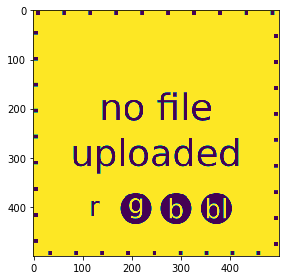

In [7]:
widget_style = {'description_width': 'initial'}
lower_thresh = widgets.IntSlider(min=0, max=100, step=5, value=2,
                                 description='lower threshold', style=widget_style)
upper_thresh = widgets.IntSlider(min=0, max=100, step=5, value=98,
                                 description='upper threshold', style=widget_style)
filter_size  = widgets.IntSlider(min=0, max=20, step=1, value=0,
                                 description='filter size', style=widget_style)

contrast_ui = widgets.VBox([lower_thresh, upper_thresh, filter_size])
contrast_tweaking = widgets.interactive_output(adjust_image, {'lower_thresh': lower_thresh,
                                                              'upper_thresh': upper_thresh,
                                                              'filter_size': filter_size,
                                                              'cmap': fixed('viridis'),
                                                              'image': image_store,
                                                              'channel': channel_selector})

In [8]:
def detect_blobs(original_image,
                 processed_image,
                 max_sigma=30,
                 threshold=0.1,
                 channel='1'
                ):
    """
    Detects bright blobs in an image using the scikit-image
    determinant of gaussian technique, then marks them on the
    image.
    
    Input: original and processed images; max_sigma to determine 
    upper limit for blob size; threshold to determine how bright
    something needs to be before it's identified as a blob.
    
    Output: displays image with red rings around detected blobs;
    returns array of blob markers (y,x,radius).
    """
    processed_image = pic.processed_image
    original_image = io.imread(original_image, plugin='imageio')
    blobs_dog = feature.blob_dog(processed_image,
                                 max_sigma=max_sigma,
                                 threshold=threshold
                                )
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2) #radius calcs
    fig,axes = plt.subplots(ncols=2, figsize=(16,12))
    plt.axis('on')
    ax_im_pairs = list(zip(axes,
                           (processed_image,
                            original_image),
                           (True,True)
                          ))
    for ax,im,draw in ax_im_pairs:
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.imshow(im)
        if draw == True:
            for blob in blobs_dog:
                y,x,r = blob
                c = plt.Circle((x, y), r,
                               color='r',
                               linewidth=2,
                               fill=False
                              )
                ax.add_patch(c)
    print("{} blobs detected.".format(len(blobs_dog)))
    pic.marks[str(channel)] = blobs_dog[:,0:2].tolist()
    
    return blobs_dog

71 blobs detected.


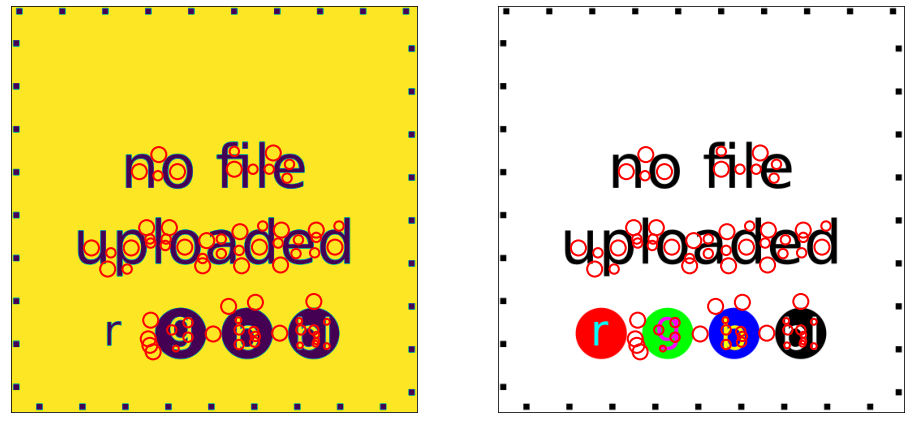

In [9]:
max_sigma = widgets.IntSlider(value=10, min=5, max=100, step=5, continuous_update=False, description='max sigma')
threshold = widgets.FloatSlider(value=0.5, min=0.01, max=1, step=0.01, continuous_update=False, description='threshold')

blob_tweak_box = widgets.VBox([max_sigma, threshold])
x = widgets.interactive_output(detect_blobs,
                           {'original_image':image_store,
                            'processed_image': fixed(pic.processed_image),
                            'max_sigma': max_sigma,
                            'threshold': threshold,
                            'channel': channel_selector}
                          )

In [10]:
prep_button = widgets.Button(description="Prep file for download")
save_button = HTML(download_button(file_contents= pic.xml_for_imagej(), filename= pic.stem + '.xml'))

def update_save_button(change):
    save_button.value = download_button(file_contents= pic.xml_for_imagej(), filename= pic.stem + '.xml')
prep_button.on_click(update_save_button)

In [11]:
blarp = widgets.HBox([filecontrol, prep_button, save_button])
blorp = widgets.HBox([contrast_ui, blob_tweak_box])
blurp = widgets.HBox([contrast_tweaking, x])
blurp.layout.height='480px'
blxrp = widgets.VBox([blarp, blorp, blurp])
display(blxrp)